In [17]:
import pandas as pd

In [18]:
df_capital = pd.read_csv('datasets/lacapital.csv')

df_capital.dropna(inplace=True)

# Limpieza y normalización de texto 

In [19]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words.add('año')
stop_words.add('años')


def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', input_str)
  return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
  return " ".join(filtered_text)

for col in df_capital.columns[:-2]:
    df_capital[col] = df_capital[col].str.lower()
    df_capital[col] = df_capital[col].str.replace('[^\w\s]', '', regex=True)
    df_capital[col] = df_capital[col].apply(remove_stopwords)
    df_capital[col] = df_capital[col].apply(remove_accents)

[nltk_data] Downloading package stopwords to /home/isaias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/isaias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Ejercicio 2

In [20]:
df_capital['categoria'].value_counts()

categoria
ovacion                  57
politica                 48
ciudad                   32
zoom                     31
policiales               22
region                   18
informacion general      17
economia                 16
mundial rugby 2023        8
mundo                     6
educacion                 4
turismo                   4
negocios                  2
cristina                  1
opinion                   1
colon                     1
baby etchecopar           1
julian montoya            1
pepin rodriguez simon     1
Name: count, dtype: int64

In [21]:
categorias = df_capital['categoria'].value_counts()
categorias = categorias[categorias >= 10].index[:5]

In [22]:
categorias_df = list()

for categoria in categorias:
    temp_df = df_capital[df_capital['categoria'] == categoria]
    categorias_df.append(temp_df.sample(22, random_state=1))

In [23]:
x = list()
y = list()

for df in categorias_df:
    x += df['titulo'].tolist()
    y += df['categoria'].tolist()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [25]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=1)

In [26]:
vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

modelo_LR = LogisticRegression(max_iter=1000)
modelo_LR.fit(x_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [27]:
y_pred_LR = modelo_LR.predict(x_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

In [28]:
print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

Precisión Regresión Logística: 0.5454545454545454
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

      ciudad       1.00      0.40      0.57         5
     ovacion       0.18      1.00      0.31         2
  policiales       1.00      0.44      0.62         9
    politica       0.67      0.67      0.67         3
        zoom       1.00      0.67      0.80         3

    accuracy                           0.55        22
   macro avg       0.77      0.64      0.59        22
weighted avg       0.88      0.55      0.61        22



In [29]:
print(modelo_LR.predict(vectorizer.transform(["en pesos", "pesos de los pumas",
                                              "pesos de los pumas con milei",
                                              "a los tiros en barrio la sexta con perotti un herido de bala, venta drogas y disparos"])))

['ovacion' 'ovacion' 'politica' 'ciudad']


# Ejercicio 3

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

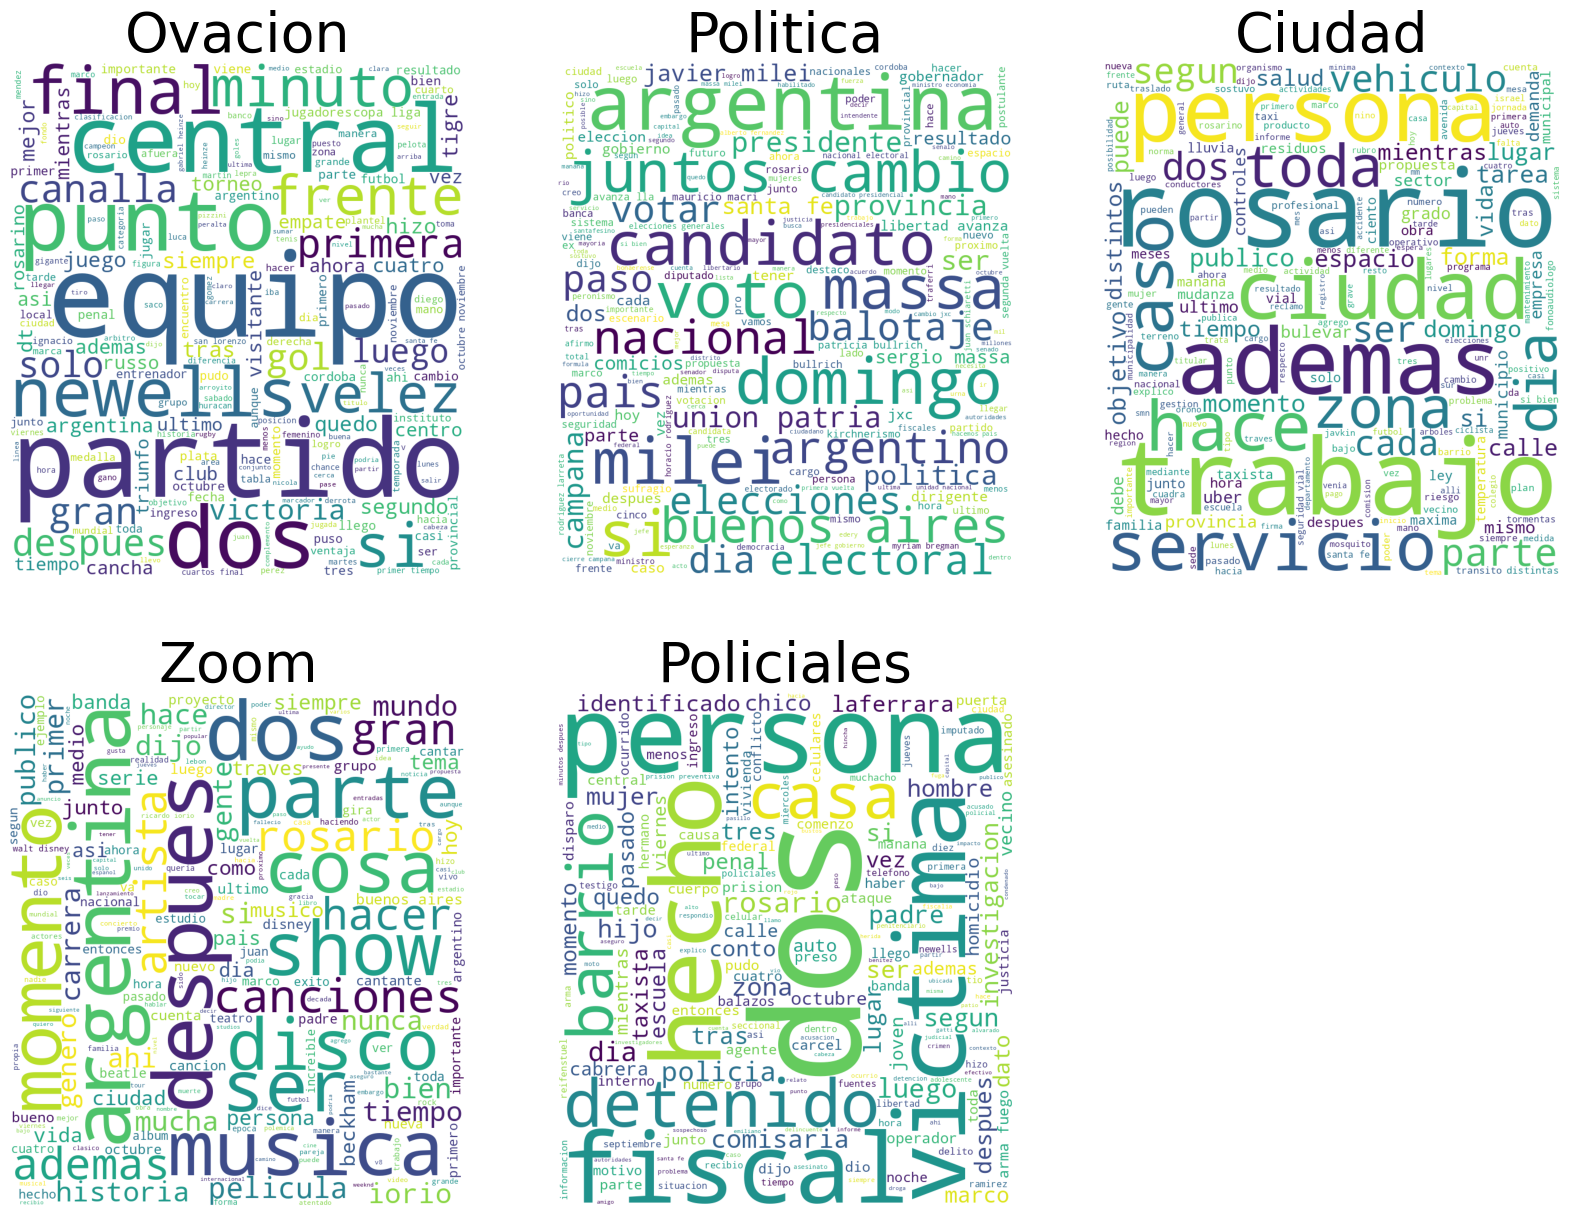

In [50]:
fig = plt.figure(figsize=(20, 15))

for idx, categoria in enumerate(categorias):
    texto = ' '.join(df_capital[df_capital['categoria'] == categoria]['texto'])

    wordcloud = WordCloud(width=800, height=900,
                            background_color='white',
                            stopwords=None,
                            min_font_size=10).generate(texto)


    ax = fig.add_subplot(2, 3, idx + 1)
    ax.imshow(wordcloud)
    plt.title(f'{categoria.capitalize()}', fontsize=40)
    plt.axis("off")


# Ejercicio 4